This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
import convokit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [2]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus"))

We will compute features over only the first 10 comments that occur in a thread, for  threads which are at least 10 comments long (controling for thread length in this way):

In [3]:
threads = corpus.utterance_threads(prefix_len=10)

In [4]:
def display_thread_helper(thread, root, indent=0):
    print(" "*indent + thread[root].user.name)
    children = [k for k, v in thread.items() if v.reply_to == root]
    for child in children:
        display_thread_helper(thread, child, indent=indent+4)
def display_thread(root):
    return display_thread_helper(threads[root],root)

The following are threads that come from the /r/canada subreddit. 

In [5]:
demo_threads = [
    # https://www.reddit.com/r/canada/comments/mmyld/polygamypolyamoury_laws_upheld_in_supreme_court/c32bcq8/
                't1_c32bcq8', 
    # https://www.reddit.com/r/canada/comments/mmd20/look_what_i_found_today_yes_and_it_is_in_canada/c322oa7/
                't1_c322oa7',
    # https://www.reddit.com/r/canada/comments/mo0lt/happy_thursday/c32hv0h/
                't1_c32hv0h'
               ]

We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, we notice that thread t1_c32bcq8 has a very linear structure, while t1_c322oa7 is flatter; to capture this difference, we might compute statistics on the distribution of in-degrees of nodes in the reply tree. We also intuit that some conversations involve a few people replying repeatedly to each other, whereas others may involve users stopping by to chime in once and then leaving; we'll later codify this difference via statistics on the indegrees and outdegrees of hypernodes (users).

In [6]:
for thread in demo_threads:
    print(thread)
    print('---')
    display_thread(thread)
    print()

t1_c32bcq8
---
drays
    QuirkyGroundhog
        Sajentine
            QuirkyGroundhog
                drays
                    QuirkyGroundhog
                        drays
                            QuirkyGroundhog
                                drays
                                    QuirkyGroundhog

t1_c322oa7
---
[deleted-t1_c322oa7]
    Aneeid
    veedubbin86
        figureskatingaintgay
            sirspate
        lovevolcano
    bunny1979
        veedubbin86
            bunny1979
    SoFaKiNg42

t1_c32hv0h
---
Can-eh-dian
    h00pla
        Switchbladeannie
        lengthynewt
            h00pla
                lengthynewt
                    h00pla
    thoriginal
    lengthynewt
    andrewmp



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.

We now extract hypergraph features. 

In [7]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo(corpus)
threads_feats = hc.retrieve_feats()

In [8]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [9]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [10]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:

In [11]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

Here are some examples of features computed over the three example threads from before:

In [12]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution. 

As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [13]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[indegree over C->C responses],0.000000,2.000000,1.000000
2nd-largest / max[indegree over C->C responses],0.500000,0.750000,0.500000
2nd-largest[indegree over C->C responses],1.000000,3.000000,2.000000
argmax[indegree over C->C responses],1.000000,0.000000,0.000000
entropy[indegree over C->C responses],1.039721,1.214890,0.955700
max[indegree over C->C responses],2.000000,4.000000,4.000000
mean-nonzero[indegree over C->C responses],1.333333,2.250000,2.333333
mean[indegree over C->C responses],1.333333,1.125000,1.166667
norm.2nd-largest[indegree over C->C responses],0.250000,0.333333,0.285714
norm.max[indegree over C->C responses],0.500000,0.444444,0.571429


Features derived from the distribution of hypernode to hypernode outdegrees in the _middle_ of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?"). 

In [14]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[outdegree over C->C mid-thread responses],1.000000,2.000000,1.000000
2nd-largest / max[outdegree over C->C mid-thread responses],0.500000,1.000000,1.000000
2nd-largest[outdegree over C->C mid-thread responses],1.000000,1.000000,1.000000
argmax[outdegree over C->C mid-thread responses],0.000000,1.000000,0.000000
entropy[outdegree over C->C mid-thread responses],1.039721,1.609438,1.098612
max[outdegree over C->C mid-thread responses],2.000000,1.000000,1.000000
mean-nonzero[outdegree over C->C mid-thread responses],1.333333,1.000000,1.000000
mean[outdegree over C->C mid-thread responses],1.333333,0.714286,0.600000
norm.2nd-largest[outdegree over C->C mid-thread responses],0.250000,0.200000,0.333333
norm.max[outdegree over C->C mid-thread responses],0.500000,0.200000,0.333333


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features _counts_ of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [15]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
count[dyadic interaction motif],4,2,2
count[external reciprocity motif],2,4,2
count[incoming triads],1,9,7
count[outgoing triads],28,17,23
count[reciprocity motif],6,1,3


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space. 

In [16]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [17]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [18]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [19]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:

In [20]:
U_df.loc[demo_threads].T

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
0,-0.763993,0.564640,0.349310
1,0.086591,0.004807,0.402699
2,-0.201495,-0.095324,0.408244
3,-0.008907,-0.471957,-0.154638
4,0.149358,0.057710,-0.191944
5,0.503707,0.596794,0.652385
6,0.303493,-0.299725,-0.250583


As well as embeddings of features:

In [21]:
V_df.loc[C_C_indegree_feats]

,0,1,2,3,4,5,6
max[indegree over C->C responses],0.710506,0.224969,-0.240780,0.496324,0.286453,1.508416e-15,0.241252
argmax[indegree over C->C responses],-0.002336,-0.573649,0.166735,0.097913,0.529625,5.021272e-15,0.594164
norm.max[indegree over C->C responses],0.109998,0.598809,0.492523,0.415606,0.460080,1.694160e-15,0.048449
2nd-largest[indegree over C->C responses],0.303793,-0.618820,0.118172,-0.153434,-0.436491,-2.152814e-15,-0.544740
2nd-argmax[indegree over C->C responses],0.219492,0.159185,-0.244122,-0.214119,-0.502880,-2.655773e-15,-0.753759
norm.2nd-largest[indegree over C->C responses],-0.244008,0.032066,0.727223,-0.294696,-0.262217,-2.217021e-15,-0.504951
mean[indegree over C->C responses],-0.213083,-0.238386,-0.299763,0.823891,-0.356075,-4.041811e-16,-0.048213
mean-nonzero[indegree over C->C responses],0.596871,0.138377,0.433496,0.515524,-0.087199,1.614421e-15,0.404115
prop-nonzero[indegree over C->C responses],-0.849557,-0.049263,-0.391765,0.265726,-0.227168,-3.358361e-16,-0.011477
prop-multiple[indegree over C->C responses],0.365520,-0.472154,0.426635,0.378047,-0.563665,-1.910571e-15,-0.028449


As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [22]:
subreddits = []
for thread_id in U_df.index:
    subreddits.append(corpus.utterances[thread_id].user.info['subreddit'])
U_df['subreddit'] = subreddits

In [23]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [24]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

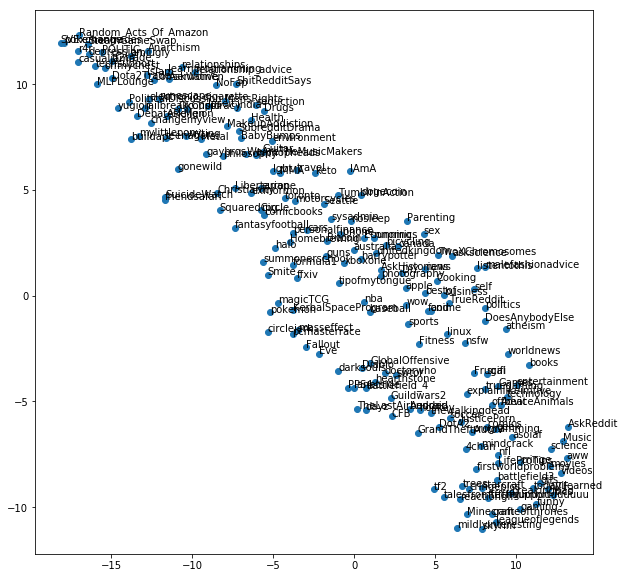

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

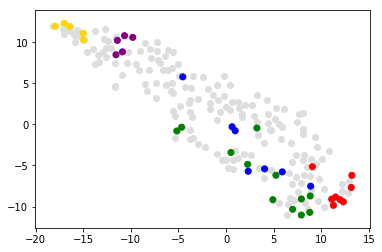

In [26]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [27]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [28]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [29]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                  p2      dist
13745            DIY  0.002236
13926            wow  0.002629
13809         bestof  0.002902
13815         canada  0.004141
13799          anime  0.005326
13744        Cooking  0.005883
13923  unitedkingdom  0.005985
13905         sports  0.006801
13897        running  0.006864
13755        Fitness  0.007233

politics
                    p2      dist
31459  DoesAnybodyElse  0.003335
31612             self  0.005498
31636        worldnews  0.011706
31504       TrueReddit  0.012328
31525         business  0.012642
31467           Frugal  0.014391
31510            anime  0.014896
31455          Cooking  0.015634
31590             nsfw  0.015745
31633       truegaming  0.015747

leagueoflegends
                        p2      dist
25983        gameofthrones  0.004793
26042               skyrim  0.007721
25984               gaming  0.008184
25963           cringepics  0.010090
25976  fffffffuuuuuuuuuuuu  0.010099
25946         battlefield3  0.011826
2591

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [36]:
from IPython.display import display

In [37]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [38]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c078wax,-0.821803,0.144343,0.010208,0.270055,-0.052510,0.445647,0.171499,bestof
t1_c162oo1,-0.821803,0.144343,0.010208,0.270055,-0.052510,0.445647,0.171499,sysadmin
t1_c3dt6wl,-0.821803,0.144343,0.010208,0.270055,-0.052510,0.445647,0.171499,SubredditDrama
t1_c0jr74g,-0.819624,0.125139,-0.005970,0.263699,-0.056101,0.451136,0.190558,WeAreTheMusicMakers
t1_c33xihb,-0.819624,0.125139,-0.005970,0.263699,-0.056101,0.451136,0.190558,IAmA
t1_c2x55nd,-0.819624,0.125139,-0.005970,0.263699,-0.056101,0.451136,0.190558,harrypotter
t1_c2z5mua,-0.818690,0.116753,0.015024,0.303625,-0.109645,0.444958,0.117016,Drugs
t1_c2w6jv0,-0.816924,0.097293,-0.001070,0.297854,-0.113996,0.450676,0.135450,pokemontrades
t1_c3254js,-0.816924,0.097293,-0.001070,0.297854,-0.113996,0.450676,0.135450,mylittlepony
t1_c0glb1h,-0.816924,0.097293,-0.001070,0.297854,-0.113996,0.450676,0.135450,SuicideWatch


,0,1,2,3,4,5,6
prop-nonzero[indegree over C->C mid-thread responses],-0.870963,-0.037875,-0.387940,0.233507,-0.186989,6.973184e-16,-0.001422
prop-nonzero[indegree over C->C responses],-0.849557,-0.049263,-0.391765,0.265726,-0.227168,-3.358361e-16,-0.011477
count[reciprocity motif],-0.841437,0.265396,0.403639,0.180257,0.140440,-1.319855e-15,-0.080056
count[reciprocity motif over mid-thread],-0.837342,0.197731,0.460133,-0.067487,0.198505,5.670982e-16,0.063878
entropy[indegree over C->c responses],-0.831430,-0.250933,-0.303808,-0.378285,0.042416,1.666622e-15,0.092517
entropy[indegree over c->c responses],-0.831430,-0.250933,-0.303808,-0.378285,0.042416,1.463376e-15,0.092517
2nd-largest[outdegree over C->c responses],-0.827351,0.266539,0.435242,-0.206965,-0.104455,-7.226179e-16,-0.035577
prop-nonzero[indegree over c->c mid-thread responses],-0.825193,-0.011626,-0.321645,-0.352923,0.186450,7.734359e-16,0.236956
prop-nonzero[indegree over c->c responses],-0.825193,-0.011626,-0.321645,-0.352923,0.186450,3.151128e-15,0.236956
prop-nonzero[indegree over C->c mid-thread responses],-0.825193,-0.011626,-0.321645,-0.352923,0.186450,8.557694e-16,0.236956


,0,1,2,3,4,5,6
subreddit,,,,,,,
casualiama,-0.699248,0.203084,0.279195,-0.081451,0.151318,0.596493,0.080769
Random_Acts_Of_Amazon,-0.685144,0.376145,0.205098,-0.174755,0.072810,0.557777,-0.008412
SteamGameSwap,-0.674723,0.256678,0.242336,-0.046239,0.093246,0.639739,0.006348
r4r,-0.659043,0.227259,0.343815,-0.094692,0.109432,0.612229,0.006393
Dota2Trade,-0.632609,0.022418,0.096140,0.046221,0.076501,0.761585,0.045395
depression,-0.620193,0.218765,0.294487,-0.003140,0.105620,0.685236,0.008186
POLITIC,-0.617011,0.153885,0.202127,0.003839,0.036805,0.742792,-0.040644
MLPLounge,-0.614435,0.177812,0.039293,-0.050739,0.017247,0.764065,0.051392
pokemontrades,-0.601041,0.327147,0.525439,-0.173563,0.106690,0.444829,-0.127510


In [ ]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

In [ ]:
top_threads = display_dimension(0, ascending=False, n=10)

In [ ]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

Another "type" of discussion surfaced at the extreme of another latent dimension corresponds to discussions which have a lot of activity in the middle of the thread, below the root  comment (indicated by the various mid-thread features which come to the fore). Subreddits here are often about more specialized topics -- e.g., programming, Bitcoin, cars.

In [ ]:
top_threads = display_dimension(1,  n=10)

In [ ]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

The following discussion type consists of threads with a particularly active latecomer (indicated by the argmax[outdegree... features). 

In [ ]:
top_threads = display_dimension(2,  n=10)

In [ ]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

And as a final example, this dimension splits the space between threads that are perfectly "flat": many comments replying to a single root (note that there are many threads of this form which share the exact same hypergraph topology as a result); and deeper discussions where multiple participants are highly active (indicated by e.g., the 2nd largest / largest, and prop-multiple features). At a higher level of aggregation we see a split between subreddits for making trades, and subreddits which are potentially more discussion-based.

In [ ]:
top_threads = display_dimension(5,  n=10)

In [ ]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

In [ ]:
top_threads = display_dimension(5, ascending=False, n=10)

In [ ]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

This dimension highlights two interesting points:

* discussion structures, as in the Facebook data, might help us draw interesting parallels between subreddits which are topically different (e.g., politics, business and sex -- certainly a somewhat clickbaity grouping). Of course, one should delve deeper into the interpretation than what we've presented here in order to make sense of this.
* There might be aspects of the _tree_ structure that we could delve into further. Reddit, in contrast to Facebook, explicitly renders all branching in the discussion tree beyond the first reply. Might there be different interactional dynamics on the two platforms as a result of this, or additional features we may have  presently neglected to include, that become especially salient on Reddit?